In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

In [3]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


# importing data
# Read the 2D array back from the text file

dir_path = "/kaggle/input/dp-5-30-2/d_big(-5_30)"
print(dir_path)
#print("Files in the directory:")
#print(os.listdir(dir_path))

data_needed = {'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}

event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}
event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}
# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'
search_pattern = os.path.join(dir_path, f'*{search_string}*')
#print(search_pattern)
matching_files = glob.glob(search_pattern)
#print(matching_files)

X = []
Y = []

for file in matching_files:
    event_type, event_name = os.path.basename(file).split('_')
    if (event_type== "DISTPAR"):
        continue
        
    if event_counter[event_type] < data_needed[event_type]:
        loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)
        X.append(loaded_data)
    
        y = [0,0,0,0]
        for key,value in event_types.items():
            if value in file.split('\\')[-1]:
                #print(value, file)
                y[key-1] = 1
                Y.append(y)
                event_counter[value] += 1
                break
 
    if all(count >= 400 for count in event_counter.values()):
        break
            
print(event_counter)  
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

/kaggle/input/dp-5-30-2/d_big(-5_30)


/tmp/ipykernel_35/690447678.py:35: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)


{'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}
(2800, 45955)
(2800, 4)


In [4]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X, Y = oversample.fit_resample(X, Y)
print(X.shape)
print(Y.shape)

(3200, 45955)
(3200, 4)


In [5]:
from sklearn.model_selection import train_test_split
print("X shape : ",X.shape)
print("Y shape : ",Y.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.25,stratify=Y, random_state=42)
print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("Y_train shape",Y_train.shape)
print("Y_test shape",Y_val.shape)

X shape :  (3200, 45955)
Y shape :  (3200, 4)
X_train shape (2400, 45955)
X_test shape (800, 45955)
Y_train shape (2400, 4)
Y_test shape (800, 4)


In [10]:
import tensorflow as tf
from keras import layers, models,regularizers
from keras.callbacks import EarlyStopping

tf.random.set_seed(42)
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(64, 4, activation='relu', input_shape=(X_train.shape[1:])+tuple([1]),kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Conv1D(32,1, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(16,1, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Dropout(0.3))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
model.summary()
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=20)

epoch = 90
# Train the model
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=64, validation_split=0.2)#,callbacks=[early_stopping])

# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print(f'accuracy on test data: {test_acc}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1838, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       375,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,332 (1.49 MB)

 Trainable params: 389,332 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.2758 - loss: 7.5834 - val_accuracy: 0.4917 - val_loss: 4.8899
Epoch 2/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.4459 - loss: 4.8280 - val_accuracy: 0.5021 - val_loss: 4.4221
Epoch 3/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5072 - loss: 4.3273 - val_accuracy: 0.4750 - val_loss: 4.0637
Epoch 4/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5960 - loss: 3.9082 - val_accuracy: 0.6583 - val_loss: 3.6519
Epoch 5/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.6312 - loss: 3.6568 - val_accuracy: 0.6542 - val_loss: 3.4834
Epoch 6/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.6647 - loss: 3.4158 - val_accuracy: 0.7167 - val_loss: 3.2178
Epoch 7/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.6666 - loss: 3.2463 - val_accuracy: 0.7083 - val_loss: 3.1351
Epoch 8/90
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.6666 - loss: 3.1304 - val_accu

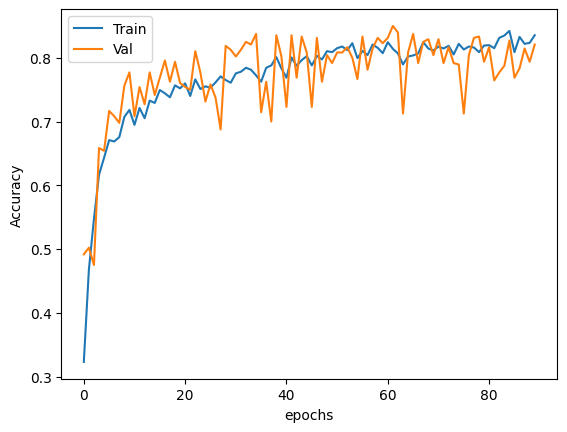

In [11]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(epoch)], history.history['accuracy'],label='Train')
plt.plot([i for i in range(epoch)], history.history['val_accuracy'],label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

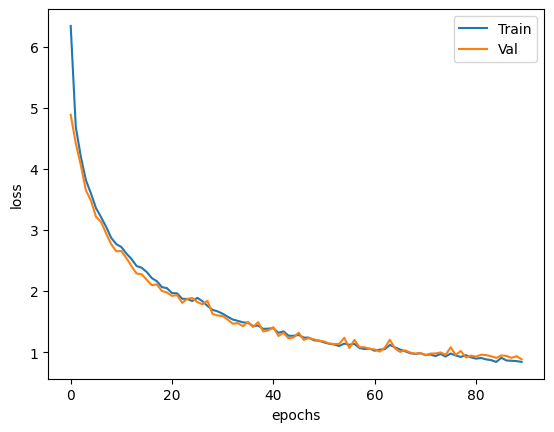

In [12]:
## import matplotlib.pyplot as plt
plt.plot([i for i in range(epoch)], history.history['loss'],label='Train')
plt.plot([i for i in range(epoch)], history.history['val_loss'],label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [13]:
import json

# Save the model
model.save('/kaggle/working/saved_(-5_30)_2m_balned_4.h5')

# Save additional details using JSON
details = {
    'dataset': '(-5_30)_2m',
    'data' : [800,800,800,800],
    'architecture': 'CNN_balanced',
    'parameters': {
        'epochs': 90,
        'batch_size': 64,
        'learning_rate': 0.001,
        '2_Drop_out':[0.4,'after_sec',0.3,'after_third'],
        'l2regularizer' : ['0.01_input','0.03_conv','0.01_dense'],
        'kernel_size':4,
        'filters':{
            'input_layer':64,
            'first_conv':32,
            'second_conv':16
        },
        'v_acc': 0.8050000071525574,
        't_acc': 0.8383333086967468,
        'Dense_layers': [64,64,64,32,4]     
    }
}

with open('/kaggle/working/model_detail_m_balned_4.json', 'w') as f:
    json.dump(details, f)


In [14]:
from keras.models import load_model

lmodel_2 = load_model(r"/kaggle/working/saved_(-5_30)_2m_balned_4.h5")
lmodel_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1838, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       375,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,334 (1.49 MB)

 Trainable params: 389,332 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:
def model_conf_u(model,X,Y,conf_threshold = 0.6):
    conf=[]
    a = 0
    w = 0
    uncert = 0

    for n in range(len(Y)):
        
        x = X[n].reshape(1, X[n].shape[0], 1)
        y = Y[n].tolist()

        y_pred = model.predict(x, verbose = 0).tolist()[0]

        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if max_value > conf_threshold:
            if y.index(max(y)) == max_index:
                conf.append(max_value)
                a = a+1
            else:
                w = w+1
        else:
            uncert = uncert+1
    
    print('confidently right', a/len(Y))
    print('confidently wrong', w/len(Y))
    print('uncertain', uncert/len(Y))

model_conf_u(lmodel_2,X,Y,0.6)

confidently right 0.7309375
confidently wrong 0.053125
uncertain 0.2159375


In [17]:
def model_conf(model, X, Y, conf_threshold=0.6):
    conf_right = []
    conf_wrong = []

    for n in range(len(Y)):
        x = X[n].reshape(1, X[n].shape[0], 1)  # Reshape each data point to (1, 45955, 1)

        y = Y[n].tolist()
        y_pred = model.predict(x, verbose=0).tolist()[0]
        
        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if y.index(max(y)) == max_index and max_value > conf_threshold:
            conf_right.append(max_value)
        else:
            conf_wrong.append(max_value)            

    return len(conf_right) / (len(conf_right) + len(conf_wrong)), conf_right, conf_wrong

a,r,w = model_conf(lmodel_2,X,Y,0.6)

print(a)
print('average conf when right',sum(r)/len(r))
print('average conf when wrong',sum(w)/len(w))

0.7309375
average conf when right 0.8961189387699843
average conf when wrong 0.5493661304730295
